In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import sklearn

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer
from perturbations import (
    PerturbationConfig,
    apply_perturbation,
    compute_untargeted_asr,
    detect_r_peaks,
    plot_triptych,
    run_attack_on_sample,
    summarize_norms,
)


In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [3]:
path = 'ptb-xl/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

### Fixing Y data for proper training format

In [4]:
mlb = MultiLabelBinarizer()
y_train_enc = mlb.fit_transform(y_train)
y_test_enc = mlb.fit_transform(y_test)
print("Encoded Labels (y_encoded):\n", y_train_enc)
print("\nClass Names (Order of Columns):\n", mlb.classes_)

Encoded Labels (y_encoded):
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]]

Class Names (Order of Columns):
 ['CD' 'HYP' 'MI' 'NORM' 'STTC']


# Model Training

## Model structure

In [5]:
# THis is the number of classes. For Superclass it will be 5, if we do all of or a subset of the subclasses there can be more or less.
NUM_CLASSES = 5

# The input shape for the dataset
IN_SHAPE = (1000,12)

model = Sequential([
    Input(IN_SHAPE),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')]
)

## Compiling and Fitting

In [6]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', # could also use categorical_crossentropy here for a single choice per input. Change output to softmax if doing that approach though
    metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
)

In [7]:
model.fit(X_train, y_train_enc)

613/613 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5887 - auc: 0.8268 - loss: 0.3987


## Testing

In [8]:
loss, accuracy, auc_score = model.evaluate(X_test, y_test_enc, verbose=1)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6347 - auc: 0.8694 - loss: 0.3554
Test Loss: 0.3554
Test Accuracy: 0.6347
Test AUC: 0.8694


## Noise Robustness Evaluation

We compare model performance on clean signals versus signals with band-limited noise applied
through the perturbation API (strength = 0.3). Adjust the configuration to explore different artefacts.


In [9]:
noise_seed = 42
noise_config = PerturbationConfig(
    ptype='band_noise',
    strength=0.3,
    center_time=5.0,
    window_seconds=None,
    extra={'beta': 0.1, 'band': (5.0, 40.0)}
)

def evaluate_clean_and_noisy(model, X_eval, y_eval, fs, noise_cfg, seed=None):
    rng = np.random.default_rng(seed) if seed is not None else None
    print('=== Clean evaluation ===')
    clean_metrics = model.evaluate(X_eval, y_eval, verbose=1)
    print(f'Clean -> Loss: {clean_metrics[0]:.4f}, Acc: {clean_metrics[1]:.4f}, AUC: {clean_metrics[2]:.4f}')
    print('=== Noisy evaluation ===')
    X_noisy = np.stack([
        apply_perturbation(x, fs=fs, config=noise_cfg, rng=rng)
        for x in X_eval
    ])
    noisy_metrics = model.evaluate(X_noisy, y_eval, verbose=1)
    print(f'Noisy -> Loss: {noisy_metrics[0]:.4f}, Acc: {noisy_metrics[1]:.4f}, AUC: {noisy_metrics[2]:.4f}')
    return clean_metrics, noisy_metrics, X_noisy

clean_metrics, noisy_metrics, X_test_noisy = evaluate_clean_and_noisy(
    model,
    X_test,
    y_test_enc,
    fs=sampling_rate,
    noise_cfg=noise_config,
    seed=noise_seed,
)


=== Clean evaluation ===
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6347 - auc: 0.8694 - loss: 0.3554
Clean -> Loss: 0.3554, Acc: 0.6347, AUC: 0.8694
=== Noisy evaluation ===
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6360 - auc: 0.8694 - loss: 0.3554
Noisy -> Loss: 0.3554, Acc: 0.6360, AUC: 0.8694


### Attack Result Logging

Collect a few `AttackResult` entries using `run_attack_on_sample` to demonstrate
the evaluation helpers on band-limited noise perturbations.


In [10]:
sample_indices = range(5)  # small subset for illustration
noise_results = []
for idx in sample_indices:
    cfg = PerturbationConfig(
        ptype='band_noise',
        strength=noise_config.strength,
        center_time=noise_config.center_time,
        window_seconds=noise_config.window_seconds,
        extra={**noise_config.extra, "record_id": int(idx)},
    )
    rng = np.random.default_rng(noise_seed + idx)
    result, _ = run_attack_on_sample(
        model,
        X_test[idx],
        y_test_enc[idx],
        cfg,
        fs=sampling_rate,
        rng=rng,
    )
    noise_results.append(result)

noise_asr = compute_untargeted_asr(noise_results)
print(f'Untargeted ASR on {len(noise_results)} samples: {noise_asr:.1%}')
summarize_norms(noise_results)


Untargeted ASR on 5 samples: 0.0%


ptype strength delta_norm_l2           delta_norm_linf        
                                mean       std            mean     std
0  band_noise      0.3      0.586753  0.035662         0.03415  0.0028

### Triptych Visualization

Visual comparison of one clean sample versus its band-noise counterpart.


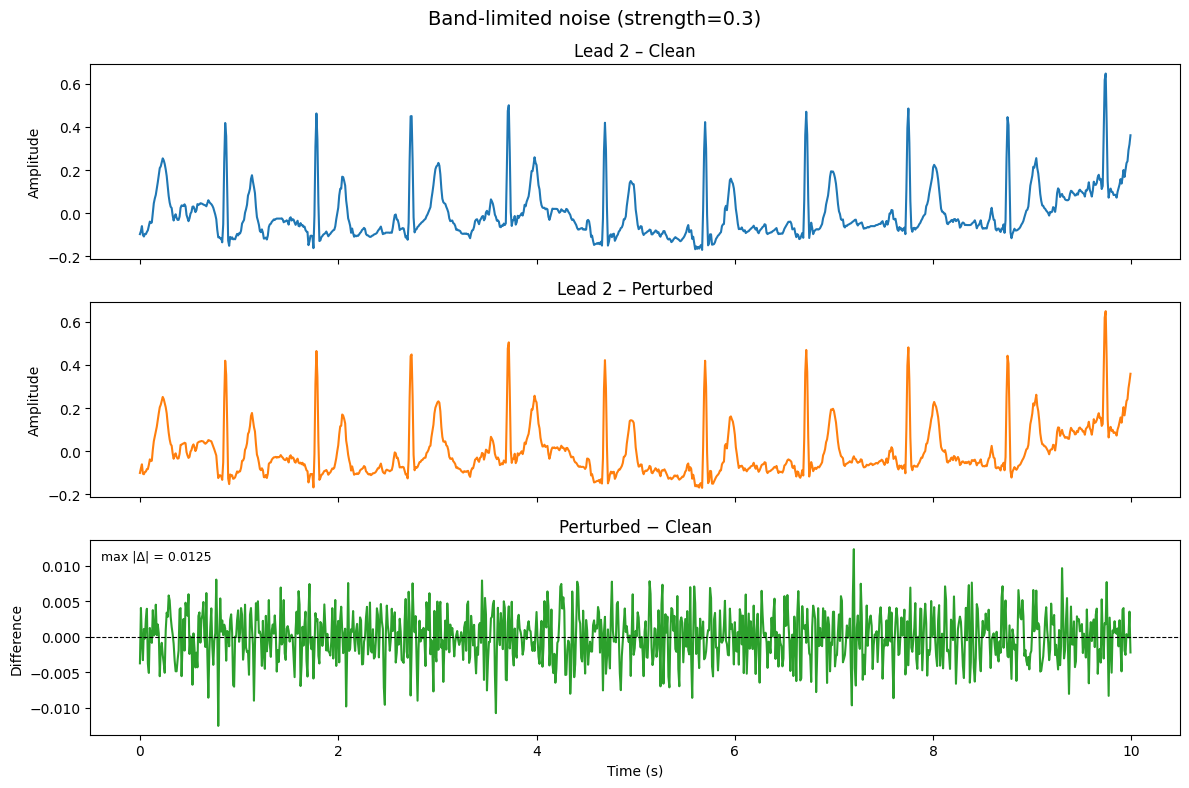

In [11]:
fig, _ = plot_triptych(
    X_test[0],
    X_test_noisy[0],
    fs=sampling_rate,
    lead_idx=1,
    title='Band-limited noise (strength=0.3)',
)
plt.show()


### Smooth Adversarial Attack Demo

Run a smooth gradient-based perturbation on one test sample and visualize the
result next to the clean waveform.


Untargeted success: False
Clean prediction: [0 0 0 1 0]
Perturbed prediction: [0 0 0 1 0]
Perturbation L2 norm: 0.0750


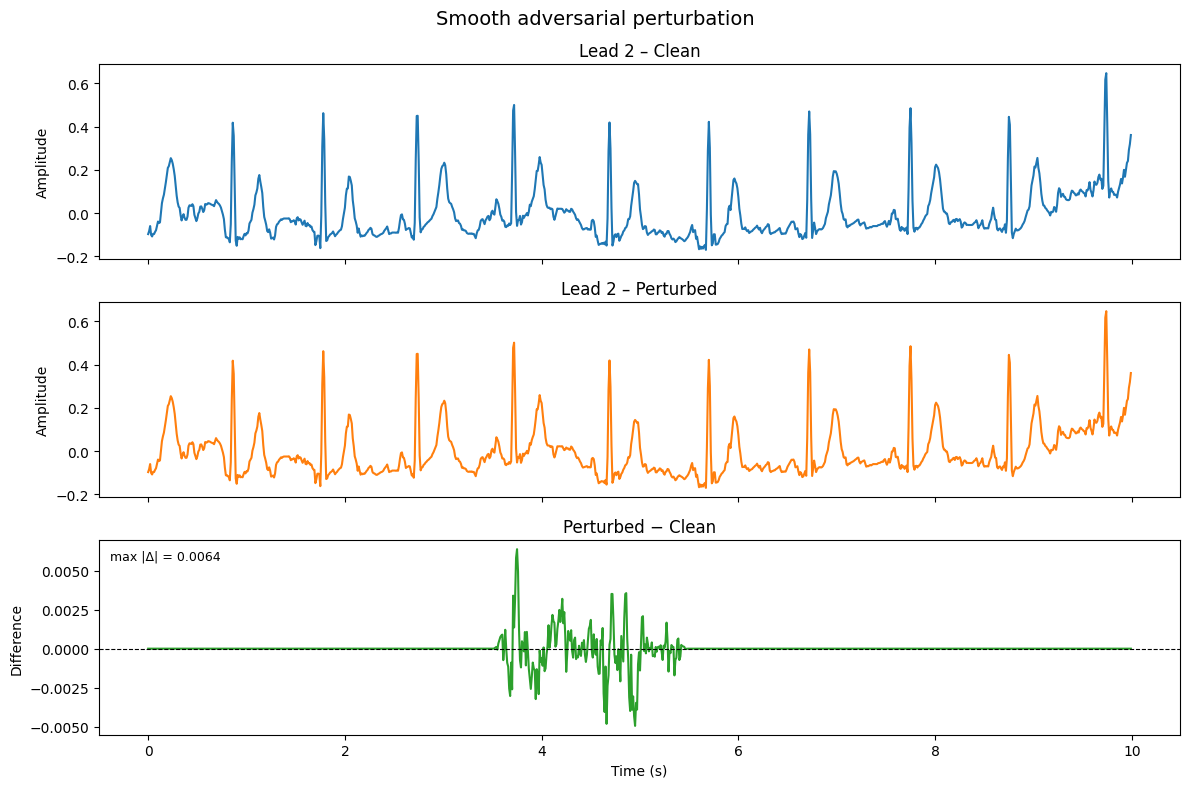

In [12]:
adv_sample_idx = 0
adv_config = PerturbationConfig(
    ptype='smooth_adv',
    strength=0.25,
    center_time=4.5,
    window_seconds=2.0,
    target_class=None,
    extra={
        'eps_global_max': 0.3,
        'steps': 100,
        'record_id': int(adv_sample_idx),
    },
)

adv_result, x_adv_demo = run_attack_on_sample(
    model,
    X_test[adv_sample_idx],
    y_test_enc[adv_sample_idx],
    adv_config,
    fs=sampling_rate,
)
print(f'Untargeted success: {adv_result.untargeted_success}')
print('Clean prediction:', adv_result.y_hat_clean)
print('Perturbed prediction:', adv_result.y_hat_adv)
print(f'Perturbation L2 norm: {adv_result.delta_norm_l2:.4f}')

fig, _ = plot_triptych(
    X_test[adv_sample_idx],
    x_adv_demo,
    fs=sampling_rate,
    lead_idx=1,
    title='Smooth adversarial perturbation',
)
plt.show()


### Morphology-Aware Perturbations

Use beat-local amplitude scaling and time warping to create plausible
morphology changes centered around detected R-peaks.


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Detected 19 R-peaks for sample 0.


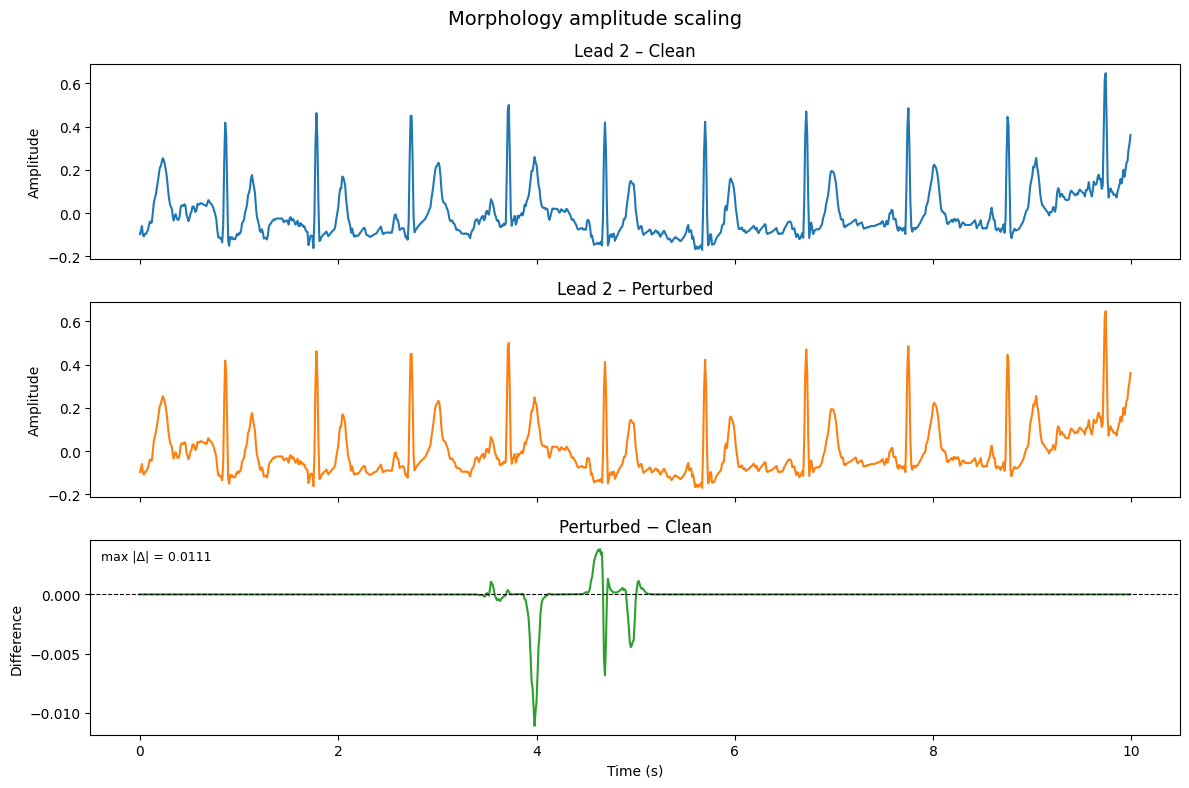

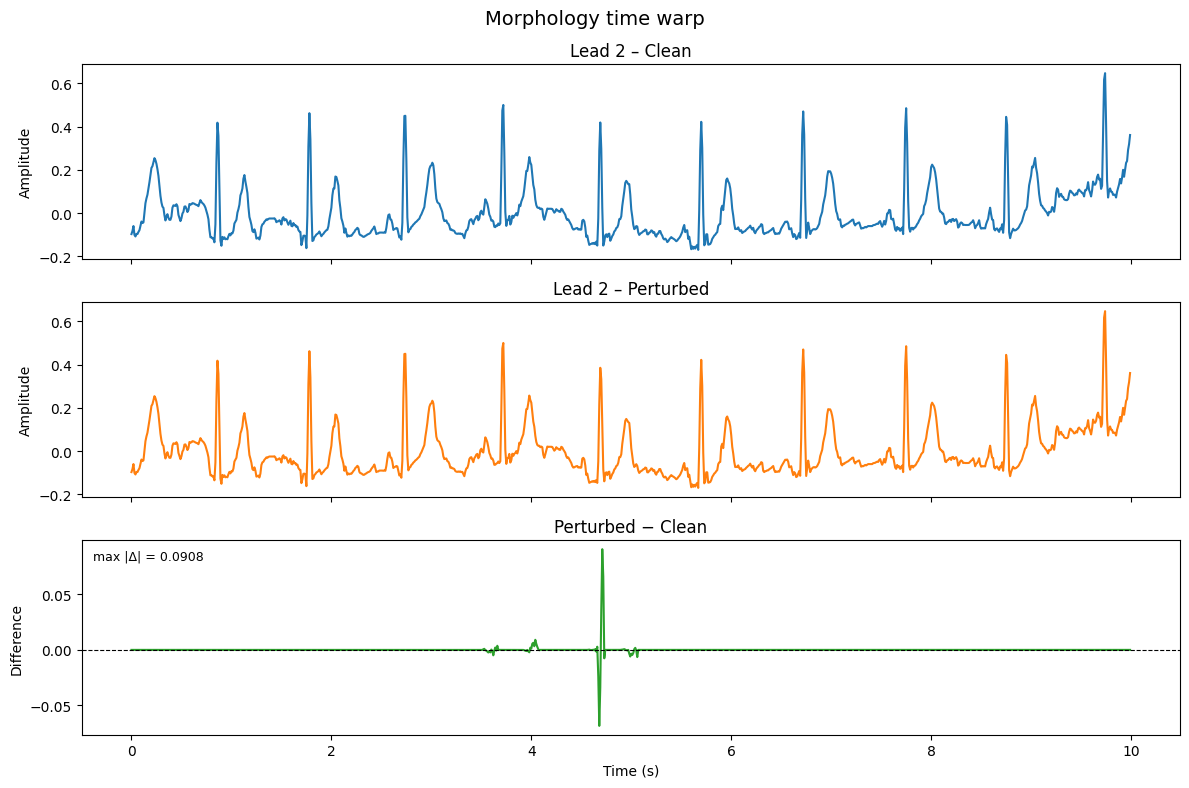

In [13]:
morph_sample_idx = 0
r_peaks_demo = detect_r_peaks(X_test[morph_sample_idx], fs=sampling_rate)
print(f"Detected {len(r_peaks_demo)} R-peaks for sample {morph_sample_idx}.")
morph_amp_config = PerturbationConfig(
    ptype='morph_amp',
    strength=0.4,
    center_time=4.5,
    window_seconds=2.0,
    extra={
        'gamma_max': 0.12,
        'sigma_ms': 60.0,
    },
)
rng = np.random.default_rng(123)
x_morph_amp = apply_perturbation(
    X_test[morph_sample_idx],
    fs=sampling_rate,
    config=morph_amp_config,
    r_peaks=r_peaks_demo,
    rng=rng,
)
fig, _ = plot_triptych(
    X_test[morph_sample_idx],
    x_morph_amp,
    fs=sampling_rate,
    lead_idx=1,
    title='Morphology amplitude scaling',
)
plt.show()

morph_time_config = PerturbationConfig(
    ptype='morph_time',
    strength=0.3,
    center_time=4.5,
    window_seconds=2.0,
    extra={
        'epsilon_max': 0.1,
        'pre_ms': 80.0,
        'post_ms': 120.0,
    },
)
x_morph_time = apply_perturbation(
    X_test[morph_sample_idx],
    fs=sampling_rate,
    config=morph_time_config,
    r_peaks=r_peaks_demo,
    rng=rng,
)
fig, _ = plot_triptych(
    X_test[morph_sample_idx],
    x_morph_time,
    fs=sampling_rate,
    lead_idx=1,
    title='Morphology time warp',
)
plt.show()
